# 线性模型可能会出错

线性意味着**单调**  假设： 任何特征的增大都会导致模型输出的增大（如果对应的权重为正）， 或者导致模型输出的减小（如果对应的权重为负）。  
对于一些问题来说,输入和输出之间可能不是线性关系:
例如，如果我们试图预测一个人是否会偿还贷款。 
我们可以认为，在其他条件不变的情况下， 收入较高的申请人比收入较低的申请人更有可能偿还贷款。   
但是，虽然收入与还款概率存在**单调性**，但它们不是线性相关的。  
收入从0增加到5万，可能比从100万增加到105万带来更大的还款可能性。  
处理这一问题的一种方法是对我们的数据进行预处理， **使线性变得更合理**，如使用收入的对数作为我们的特征。  
  
然而我们可以很容易找出违反单调性的例子，例如：  
们想要根据体温预测死亡率。 对体温高于37摄氏度的人来说，温度越高风险越大。 然而，对体温低于37摄氏度的人来说，温度越高风险就越低。 
在这种情况下，我们也可以通过一些巧妙的预处理来解决问题。 例如，我们可以使用**与37摄氏度的距离**作为特征。  
  
但是，如何对猫和狗的图像进行分类呢？   
增加位置(13,17)处像素的强度是否总是增加（或降低）图像描绘狗的似然？   
对 **线性模型的依赖**对应于一个隐含的假设， 即区分猫和狗的唯一要求是评估单个像素的强度。  
在一个倒置图像后依然保留类别的世界里，这种方法注定会失败。  


# 在网络中加入隐藏层
可以通过在网络中加入  **一个或多个隐藏层**  来克服线性模型的限制  
最简单的方法是将许多全连接层堆叠在一起。 每一层都输出到上面的层，直到生成最后的输出。   
我们可以把前层看作表示，把最后一层看作线性预测器。  
我们称之为  **MLP**

# 从线性到非线性
假设我们不引入非线性的操作，那么对任意输入X,对应的隐藏层H关系为:
$$H = XW^{(1)} + b^{(1)}$$
而对于H 和输出 O 的关系为:
$$O = HW^{(2)} + b^{(2)}$$
显然有:
$$O = XW^{(1)}W^{(2)} + b^{(1)}W^{(2)}+b^{(2)}$$
等价于
$$O = XW^{(3)} + b^{(3)}$$
其中
$$W^{(3)} = W^{(1)}W^{(2)} \quad b^{(3)} =b^{(1)}W^{(2)}+b^{(2)} $$
因此，假如不引入非线性操作，我们的两层关系将会毫无意义。  
  
为了发挥多层架构的潜力， 我们还需要一个额外的关键要素： 在仿射变换之后对每个隐藏单元应用非线性的激活函数（activation function）
。 激活函数的输出:被称为活性值（activations）。 一般来说，有了激活函数，就不可能再将我们的多层感知机退化成线性模型：
计激活函数为 $\sigma$  
有:  
$$H = \sigma(XW^{(1)} + b^{(1)})$$
$$O = HW^{(2)} + b^{(2)}$$
这样我们便引入了非线性关系

# 常见激活函数
  
## Relu
$$ Relu(x) = max(x,0) $$
## sigmoid
$$ sigmoid(x) = \frac{1}{1+exp(-x)}$$
## tanh
$$ tanh(x) = \frac{1-exp(-2x)}{1+exp(-2x)}$$

# 从零开始实现多层感知机

In [24]:

from torch.utils import data
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn 

In [25]:
def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [30]:

num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens,requires_grad = True)*0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens),requires_grad = True)
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs,requires_grad = True)*0.01)
b2 = nn.Parameter(torch.zeros(num_outputs),requires_grad = True)
params = [W1, b1, W2, b2]

batch_size = 256 
train_iter, test_iter = load_data_fashion_mnist(batch_size)

def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [31]:
def net(X):
    X = X.reshape((-1,num_inputs))
    H = relu(X@W1 + b1)
    return (H@W2 + b2)

In [28]:
loss = nn.CrossEntropyLoss()
#reduction 参数用于控制损失函数的输出形式，即是否对每个样本的损失值进行聚合（如求和、求平均等）。
#'none' 不聚合
#'mean' 求均值
#'sum' 求总和

In [33]:
num_epoch,lr = 10,0.1
updater = torch.optim.SGD(params,lr = lr)
def accuracy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)  # 取 logits 的最大值索引作为预测类别
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


for epoch in range(num_epoch):
    train_l_sum = 0.0  # 总损失
    train_acc_sum = 0.0  # 总正确数
    n = 0  # 总样本数
    for X,y in train_iter:
        updater.zero_grad()
        y_hat = net(X)
        l = loss(y_hat,y)
        l.backward()
        updater.step()

        train_l_sum += l.item() * y.shape[0]  # 乘以批次大小（损失函数默认返回平均值）
        train_acc_sum += accuracy(y_hat, y)
        n += y.shape[0]
    train_loss = train_l_sum / n
    train_acc = train_acc_sum / n
    print(f'Epoch {epoch + 1}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}') 

Epoch 1, Loss: 1.0421, Accuracy: 0.6498
Epoch 2, Loss: 0.6025, Accuracy: 0.7873
Epoch 3, Loss: 0.5223, Accuracy: 0.8171
Epoch 4, Loss: 0.4819, Accuracy: 0.8299
Epoch 5, Loss: 0.4524, Accuracy: 0.8413
Epoch 6, Loss: 0.4337, Accuracy: 0.8477
Epoch 7, Loss: 0.4161, Accuracy: 0.8533
Epoch 8, Loss: 0.4046, Accuracy: 0.8572
Epoch 9, Loss: 0.3941, Accuracy: 0.8605
Epoch 10, Loss: 0.3829, Accuracy: 0.8651


In [34]:
#标签转换
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]
#展示图像
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

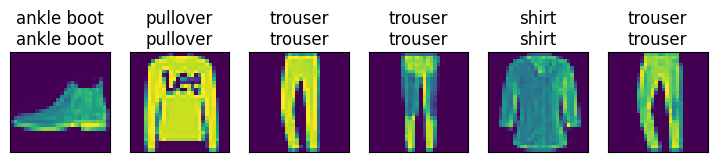

In [35]:
for X, y in test_iter:
        break
trues = get_fashion_mnist_labels(y)
preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
show_images(
    X[0:6].reshape((6, 28, 28)), 1, 6, titles=titles[0:6])
plt.show()  # 修复问题2：调用 plt.show() 显示图像

# MLP的简洁实现

In [41]:
net = nn.Sequential(nn.Flatten(),nn.Linear(784,256),nn.ReLU(),nn.Linear(256,10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights)
    

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [42]:
batch_size,lr,num_epoch  = 256,0.1,10
loss = nn.CrossEntropyLoss()
updater = torch.optim.SGD(net.parameters(),lr = lr)
train_iter, test_iter = load_data_fashion_mnist(batch_size)

for epoch in range(num_epoch):
    train_l_sum = 0.0  # 总损失
    train_acc_sum = 0.0  # 总正确数
    n = 0  # 总样本数
    for X,y in train_iter:
        updater.zero_grad()
        y_hat = net(X)
        l = loss(y_hat,y)
        l.backward()
        updater.step()

        train_l_sum += l.item() * y.shape[0]  # 乘以批次大小（损失函数默认返回平均值）
        train_acc_sum += accuracy(y_hat, y)
        n += y.shape[0]
    train_loss = train_l_sum / n
    train_acc = train_acc_sum / n
    print(f'Epoch {epoch + 1}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}') 

Epoch 1, Loss: 1.0440, Accuracy: 0.6468
Epoch 2, Loss: 0.5992, Accuracy: 0.7898
Epoch 3, Loss: 0.5187, Accuracy: 0.8172
Epoch 4, Loss: 0.4803, Accuracy: 0.8330
Epoch 5, Loss: 0.4533, Accuracy: 0.8401
Epoch 6, Loss: 0.4331, Accuracy: 0.8480
Epoch 7, Loss: 0.4182, Accuracy: 0.8513
Epoch 8, Loss: 0.4014, Accuracy: 0.8586
Epoch 9, Loss: 0.3897, Accuracy: 0.8625
Epoch 10, Loss: 0.3814, Accuracy: 0.8653


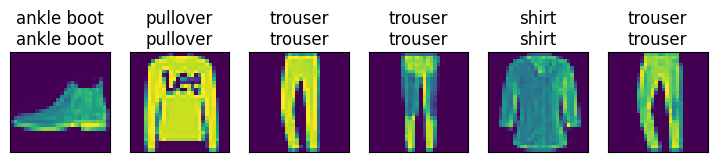

In [43]:
for X, y in test_iter:
        break
trues = get_fashion_mnist_labels(y)
preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
show_images(
    X[0:6].reshape((6, 28, 28)), 1, 6, titles=titles[0:6])
plt.show()  # 修复问题2：调用 plt.show() 显示图像